# Fake News prediction

What are fake news?
...

## Libary import

In [701]:
reset -fs

In [702]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import percentile

## Loading data

In [703]:
data_o = pd.read_csv('overview.csv')
data_o.veracity.value_counts()

mostly true                  1264
mixture of true and false     212
mostly false                   87
no factual content             64
Name: veracity, dtype: int64

In [704]:
data = pd.read_csv('BuzzData.csv')

In [705]:
data.sample(5)

,article,prediction
747,It was only a matter of time before the milita...,3
842,After collapsing just before trying to step ...,1
1076,“Rather than end dangerous politically-driven ...,0
949,"As we know, the final United Nations General A...",3
1524,A powerful exchange between a veteran and a po...,3


In [706]:
data.article[42]

"There have been so many deaths in country music over the past couple of months, and we thought that we were going to have to say goodbye to another legend Saturday night. It was a normal Saturday night at the Cornstock Concert on the Hill in Garnett, Kansas until Eddie Montgomery collapsed on stage in the middle of his performance. Many of you probably know the country star from the country duo Montgomery Gentry.  Montgomery Gentry was founded in 1999 when Eddie Montgomery and Troy Gentry came together and graced us all with their talents. The country duo has released 6 studio albums since their big debut and has had several No. 1 hits such as “If You Ever Stop Loving Me”, “Something to Be Proud Of”, “Lucky Man”, “Back When I Knew It All” and “Roll with Me”. The duo rose to fame shortly after the start of their career and they have continued to be a country favorite over the years. The duo was performing at their concert Saturday (September 24th) when Eddie Montgomery collapsed on the

## Looking at data

###  Mean of length article (in words)

In [707]:
for x in data.article:
    len_article = np.mean(len(x.split()))

In [708]:
len_article

215.0

### Distribution of article (by length)

In [709]:
# create column for length of article
dist_article = []
for x in data.article:
    dist_article.append(len(x.split()))
data['Article_length'] = dist_article

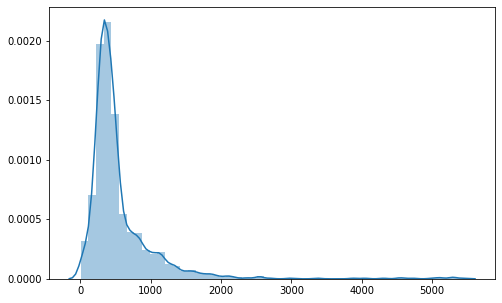

In [710]:
plt.figure(figsize=(8,5))
ax = sns.distplot(dist_article)

### Distribution by subject

# Data cleaning

- check for missing values
- remove empty article
- check for duplicated article
- combine categories
- remove outlier

In [711]:
#check for missing values
data.isnull().sum()

article           0
prediction        0
Article_length    0
dtype: int64

In [712]:
#find empty article 
empty_list = data[data['article'] == 'The document has moved here.']
print(len(empty_list))
print(empty_list)

14
                           article  prediction  Article_length
94    The document has moved here.           3               5
145   The document has moved here.           3               5
308   The document has moved here.           1               5
429   The document has moved here.           0               5
724   The document has moved here.           3               5
846   The document has moved here.           2               5
908   The document has moved here.           3               5
913   The document has moved here.           0               5
1003  The document has moved here.           3               5
1081  The document has moved here.           2               5
1137  The document has moved here.           1               5
1335  The document has moved here.           3               5
1456  The document has moved here.           3               5
1461  The document has moved here.           2               5


In [713]:
# drop empty articles
data.drop(data[data['article'] == 'The document has moved here.'].index , inplace=True)
data.shape

(1590, 3)

In [714]:
# find dupilcated article
dupl = data[data.duplicated(['article'])]
print(len(dupl))
print(dupl)

34
                                                article  prediction  \
223   (CNN)The circus of politics can often be a dis...           2   
231   (CNN)Hillary Clinton forced Donald Trump onto ...           3   
276   (CNN)Debate stages have long doubled as presid...           3   
332   Washington (CNN)Republicans are preparing for ...           3   
376   Washington (CNN)The battle over gun rights ret...           3   
474   (CNN)Ukrainian President Petro Poroshenko says...           3   
570   Washington (CNN)New York City Mayor Bill de Bl...           3   
734   WashingtonSince we last updated the CNN battle...           3   
771   (CNN)Sen. Jeff Sessions pilloried former Presi...           3   
829   Washington (CNN)The cast of "The West Wing" is...           3   
1023  (CNN)Even if their preferred candidate wins, a...           3   
1128  (CNN)Hillary Clinton holds a solid 6-point lea...           3   
1158  Washington (CNN)Hillary Clinton and Donald Tru...           3   
116

In [715]:
# remove duplicate
data.drop_duplicates(keep='first', inplace=True)
data.shape

(1557, 3)

In [716]:
#removes = data.article.isin(["EDITOR’S NOTE:"]).index

In [717]:
#CNN

In [718]:
#combine and drop categories of prediciton
data.prediction.unique()
data.prediction.value_counts()

3    1210
0     206
1      80
2      61
Name: prediction, dtype: int64

In [719]:
#data.prediction.drop(['2'])
index_2 = data[data['prediction'] == 2].index
data.drop(index_2, inplace=True)

In [720]:
data.shape

(1496, 3)

In [721]:
# combine prediction of mostly & mixture of true and false since we are looking for fake news
# -> dataset with prediction: 0 = mostly True news
#                             1 = mostly Fake News and article with some fake news
data.prediction.replace(0, 1, inplace = True)
data.prediction.replace(3, 0, inplace = True)
data.prediction.value_counts()

0    1210
1     286
Name: prediction, dtype: int64

## Handling outliers
since we know that the distribution of length of words in the sample is not Gaussian,
we can not use the standard deviation of the sample as a cut-off 
therefore we use Interquartile Range Method

In [737]:
# calculate interquartile range
q25, q75 = percentile(data.Article_length, 25), percentile(data.Article_length, 75)
iqr = q75 - q25
print('Percentiles: 25th=%.3f, 75th=%.3f, IQR=%.3f' % (q25, q75, iqr))
# calculate the outlier cutoff
cut_off = iqr * 1.5
lower, upper = q25 - cut_off, q75 + cut_off
# identify outliers
outliers = [idx for idx,x in data.Article_length.iteritems() if x < lower or x > upper]
print('Identified outliers: %d' % len(outliers))
# remove outliers
outliers_removed = [x for x in data.Article_length if x >= lower and x <= upper]
print('Non-outlier observations: %d' % len(outliers_removed))

Percentiles: 25th=307.000, 75th=599.500, IQR=292.500
Identified outliers: 161
Non-outlier observations: 1335


In [738]:
len(outliers)

161

In [745]:
# remove outlier
data.Article_length.drop(outliers, inplace=True)

KeyError: '[  14   18   22   30   45   58   79   88  121  137  146  153  155  166\n  181  195  211  221  230  248  255  259  283  312  354  380  383  410\n  425  426  432  450  460  473  475  483  493  498  503  507  513  519\n  532  542  559  573  580  595  599  601  607  611  614  616  617  619\n  636  638  642  651  660  664  670  671  676  681  682  685  691  693\n  711  712  736  740  757  770  796  800  806  809  813  818  820  851\n  857  863  879  881  884  902  914  915  928  929  955  964  965  966\n  970  973 1001 1017 1019 1021 1030 1031 1048 1063 1064 1066 1092 1096\n 1104 1110 1111 1117 1121 1132 1140 1143 1160 1169 1181 1186 1210 1238\n 1267 1271 1273 1277 1283 1285 1295 1310 1311 1317 1338 1339 1363 1365\n 1376 1377 1380 1386 1387 1392 1397 1425 1438 1446 1454 1463 1464 1469\n 1478 1517 1522 1568 1572 1573 1589] not found in axis'

In [746]:
data.shape

(1335, 3)

# Exploratory data analysis (EDA)

## Fake News and True News

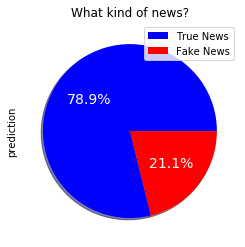

In [747]:
Fig_age_survivial = (data.prediction.value_counts()
                     .plot.pie(autopct='%1.1f%%'
                               ,shadow=True
                               ,colors=['blue','red']
                               ,textprops=dict(color="w",size='14'))
                    )
plt.title('What kind of news?')
plt.legend(['True News','Fake News'])
plt.savefig('figures/News_pie.png')

## Article length

In [749]:
dist_article = []
for x in data.article:
    dist_article.append(len(x.split()))
data['Article_length'] = dist_article

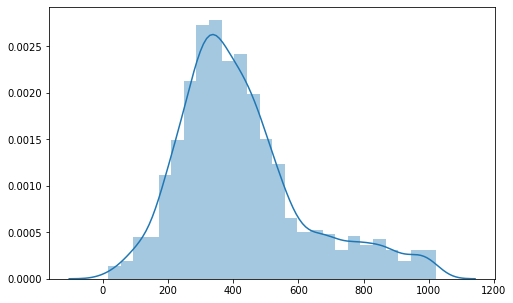

In [750]:
plt.figure(figsize=(8,5))
ax = sns.distplot(dist_article)

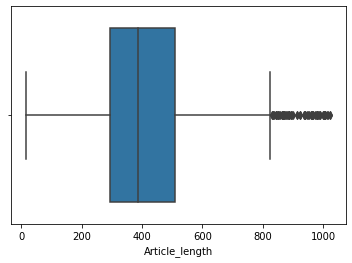

In [751]:
# boxplot 
ax = sns.boxplot(x=data["Article_length"])

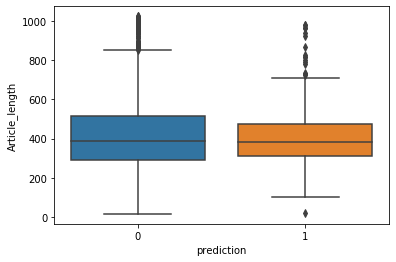

In [752]:
# boxplot by prediction
ax = sns.boxplot(x="prediction", y="Article_length", data=data)

In [755]:
data.shape

(1335, 3)

## Subject

In [637]:
# pie chart for subject
# boxplot for subject